In [1]:
import calendar
import re
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
np.random.seed(42)

from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})

%matplotlib inline

In [2]:
#Read weather dataset in csv format
df_weather=pd.read_csv('../data/weather.csv') 

## Weather Dataset - Initial EDA

In [3]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [4]:
df_weather.shape

(2944, 22)

There are 22 columns and 2,944 rows in the weather dataset provided.

In [5]:
df_weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


There are two weather stations in the dataset which corresponds to: 
- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [6]:
df_weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

Some of the columns have inappropriate data types which should be converted into proper format during cleaning.

- Date - object to Datetime format, 

- Tavg, Depart,WetBulb, Heat, Cool, Sunrise, Sunset - object to integer format

- SnowFall, PrecipTotal, StnPressure, SeaLevel, AvgSpeed - object to float format

In [7]:
# function to label T,M,- with 1 or 0
def count_of_t(x):
     if x == '  T':
        return 1 
     else:
        return 0
def count_of_m(x):
     if x == 'M':
        return 1
     else:
        return 0
def count_dash(x):
     if x == '-':
        return 1
     else:
        return 0
# count total number of M - T in df
def print_summary(df):
    cols = ['column', 'M', '-', 'T']
    df_summary = pd.DataFrame(columns=cols)
    idx = 0
    for col in df.columns:
        if df[col].dtype == 'object':
            total_m = df[col].apply(count_of_m).sum()
            total_dash = df[col].apply(count_dash).sum()
            total_t = df[col].apply(count_of_t).sum()
            df_summary.at[idx, cols[0]] = col
            df_summary.at[idx, cols[1]] = total_m
            df_summary.at[idx, cols[2]] = total_dash
            df_summary.at[idx, cols[3]] = total_t
        idx += 1
    return df_summary

In [8]:
weather_summary = print_summary(df_weather)
weather_summary

,column,M,-,T
1,Date,0,0,0
4,Tavg,11,0,0
5,Depart,1472,0,0
7,WetBulb,4,0,0
8,Heat,11,0,0
9,Cool,11,0,0
10,Sunrise,0,1472,0
11,Sunset,0,1472,0
12,CodeSum,0,0,0
13,Depth,1472,0,0


The following have been noted from the weather dataset where 'M' represents missing values, 'T' represents trace amounts which are too small for the readings to be recorded and '-' represents blank values:
- There are 11 M values for Tavg column.
- There are 1472 M values for Depart column.
- There are 4 M values for WetBulb column.
- There are 11 M values for Heat column.
- There are 11 M values for Cool column.
- There are 1472 blank values for Sunrise column.
- There are 1472 blank values for Sunset column.
- There are 1472 M values for Depth column.
- There are 2944 M values for Water1 column.
- There are 1472 M values and 12 T values for SnowFall column.
- There are 2 M values and 318 T values for PrecipTotal column.
- There are 4 M values for StnPressure column.
- There are 9 M values for SeaLevel column.
- There are 3 M values for AvgSpeed column.

In [9]:
weather_stn1= df_weather[df_weather['Station']==1]
weather_stn2= df_weather[df_weather['Station']==2]
weather_stn1=weather_stn1.drop('Station',axis=1)
weather_stn2=weather_stn2.drop('Station',axis=1)

In [10]:
weather_summary_stn1 = print_summary(weather_stn1)
print('---station1----')
weather_summary_stn1

---station1----


,column,M,-,T
0,Date,0,0,0
3,Tavg,0,0,0
4,Depart,0,0,0
6,WetBulb,3,0,0
7,Heat,0,0,0
8,Cool,0,0,0
9,Sunrise,0,0,0
10,Sunset,0,0,0
11,CodeSum,0,0,0
12,Depth,0,0,0


The following have been noted from the weather station 1 where 'M' represents missing values, 'T' represents trace amounts which are too small for the readings to be recorded and '-' represents blank values:
- There are 3 M values for WetBulb column.
- There are 1472 M values for Water1 column.
- There are 12 T values for SnowFall column.
- There are 163 T values for PrecipTotal column.
- There are 2 M values for StnPressure column.
- There are 5 M values for SeaLevel column.

In [11]:
weather_summary_stn2 = print_summary(weather_stn2)
print('---station2----')
weather_summary_stn2

---station2----


,column,M,-,T
0,Date,0,0,0
3,Tavg,11,0,0
4,Depart,1472,0,0
6,WetBulb,1,0,0
7,Heat,11,0,0
8,Cool,11,0,0
9,Sunrise,0,1472,0
10,Sunset,0,1472,0
11,CodeSum,0,0,0
12,Depth,1472,0,0


The following have been noted from the weather station 2 where 'M' represents missing values, 'T' represents trace amounts which are too small for the readings to be recorded and '-' represents blank values:
- There are 11 M values for Tavg column.
- There are 1472 M values for Depart column.
- There are 1 M values for WetBulb column.
- There are 11 M values for Heat column.
- There are 11 M values for Cool column.
- There are 1472 blank values for Sunrise column.
- There are 1472 blank values for Sunset column.
- There are 1472 M values for Depth column.
- There are 1472 M values for Water1 column.
- There are 1472 M values for SnowFall column.
- There are 2 M values and 155 T values for PrecipTotal column.
- There are 2 M values for StnPressure column.
- There are 4 M values for SeaLevel column.
- There are 3 M values for AvgSpeed column.

## Weather Dataset - Cleaning & Imputation of Data

In [12]:
# 'M','-' in weather data is a missing value; convert all instances to np.nan
df_weather.replace(to_replace='M', value=np.nan, inplace=True)
df_weather.replace(to_replace='-', value=np.nan, inplace=True)

In [13]:
# Convert the dates to datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [14]:
#Amending columns to Datetime format
df_weather['year'] = pd.DatetimeIndex(df_weather['Date']).year
df_weather['day'] = pd.DatetimeIndex(df_weather['Date']).day
df_weather['month'] = pd.DatetimeIndex(df_weather['Date']).month
df_weather['month'] = df_weather['month'].apply(lambda x: calendar.month_abbr[x])

In [15]:
#changing the values 11 'M' values to the straight average in 'Tavg'
new_vals = []

for i, x in enumerate(df_weather['Tavg']):
    if x != x:
        avg = (df_weather['Tmax'].loc[i] + df_weather['Tmin'].loc[i]) / 2
        new_vals.append(avg)
    else:
        new_vals.append(x)
        
df_weather['Tavg'] = new_vals
df_weather['Tavg'] = df_weather['Tavg'].astype(int)

In [16]:
#changing the values 11 'M' values to the formula for 'Heat'(Heating Degree Day - Base 65F)
new_vals1 = []

for i, x in enumerate(df_weather['Heat']):
    if x != x:
        if df_weather['Tavg'].loc[i] < 65:
            hdd = 65 - df_weather['Tavg'].loc[i]
            new_vals1.append(hdd)
        else:
            hdd = 0
            new_vals1.append(hdd)
    else:
        new_vals1.append(x)
        
df_weather['Heat'] = new_vals1
df_weather['Heat'] = df_weather['Heat'].astype(int)

In [17]:
#changing the values 11 'M' values to the formula for 'Cool'(Cooling Degree Day - Base 65F)
new_vals2 = []

for i, x in enumerate(df_weather['Cool']):
    if x != x:
        if df_weather['Tavg'].loc[i] > 65:
            hdd = df_weather['Tavg'].loc[i] - 65
            new_vals2.append(hdd)
        else:
            hdd = 0
            new_vals2.append(hdd)
    else:
        new_vals2.append(x)
        
df_weather['Cool'] = new_vals2
df_weather['Cool'] = df_weather['Cool'].astype(int)

In [18]:
#changing the values 4 'M' values to the formula for 'WetBulb'(Cooling Degree Day - Base 65F)
new_vals3 = []

for i, x in enumerate(df_weather['WetBulb']):
    if x != x:
        wb = df_weather['Tavg'].loc[i] - ((df_weather['Tavg'].loc[i] - df_weather['DewPoint'].loc[i])/3)
        new_vals3.append(wb)
    else:
        new_vals3.append(x)
        
df_weather['WetBulb'] = new_vals3
df_weather['WetBulb'] = df_weather['WetBulb'].astype(int)

In [19]:
# Drop columns with over half NANs
df_weather.drop(['Depart', 'Depth', 'Water1'], axis=1, inplace=True)

In [20]:
#Forward filling missing values in stnPressure/Avgspeed/SeaLevel/Sunrise/Sunset
df_weather['StnPressure'] = df_weather['StnPressure'].fillna(method='ffill').astype(float)
df_weather['AvgSpeed'] = df_weather['AvgSpeed'].fillna(method='ffill').astype(float)
df_weather['SeaLevel'] = df_weather['SeaLevel'].fillna(method='ffill').astype(float)
df_weather['Sunrise'] = df_weather['Sunrise'].fillna(method='ffill').astype(int)
df_weather['Sunset'] = df_weather['Sunset'].fillna(method='ffill').astype(int)

In [21]:
#Amend wrongly imputed values for Sunset
df_weather['Sunset'] = df_weather['Sunset'].replace(1860,1900)
df_weather['Sunset'] = df_weather['Sunset'].replace(1760,1800)
df_weather['Sunset'] = df_weather['Sunset'].replace(1660,1700)

In [22]:
#Changing the 'T' for trace rain to a quantity of 0.001, forward filling 'M' values
df_weather['PrecipTotal'] = df_weather['PrecipTotal'].apply(lambda x: 0.001 if x == '  T' else x).fillna(method='ffill').astype(float)

In [23]:
#Changing the 'T' for trace snowfall to a quantity of 0.01, forward filling 'M' values
df_weather['SnowFall'] = df_weather['SnowFall'].apply(lambda x: 0.01 if x == '  T' else x).fillna(method='ffill').astype(float)

In [24]:
# Now identify number of missing values in each column
df_weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
year           0
day            0
month          0
dtype: int64

No null values are present in the weather dataset after cleaning. All 'T', 'M' & ' ' values have been imputed.

In [25]:
#Convert CodeSum column into a set of unique values
list_code_sum = []

def get_code_sum_elems(code_sum_string):
    global list_code_sum
    list_code_sum.extend(code_sum_string.split())
    return True

for i in df_weather['CodeSum']:
    get_code_sum_elems(i.strip())
    
set_code_sum = set(list_code_sum)
print(set_code_sum)

{'RA', 'VCTS', 'TS', 'GR', 'SN', 'BCFG', 'TSRA', 'FG+', 'VCFG', 'DZ', 'BR', 'HZ', 'FG', 'MIFG', 'FU', 'SQ'}


In [26]:
for i in set_code_sum:
    df_weather[i] = 0

In [27]:
#Get dummies for unique values of CodeSum column
for i, r in df_weather.iterrows():
    list_cs = r['CodeSum'].split()
    for j in list_cs:
        if j in set_code_sum:
            df_weather.loc[i,j]=1

In [28]:
# Drop CodeSum column
df_weather.drop(['CodeSum'], axis=1, inplace=True)

In [29]:
df_weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int64
DewPoint                int64
WetBulb                 int64
Heat                    int64
Cool                    int64
Sunrise                 int64
Sunset                  int64
SnowFall              float64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
year                    int64
day                     int64
month                  object
RA                      int64
VCTS                    int64
TS                      int64
GR                      int64
SN                      int64
BCFG                    int64
TSRA                    int64
FG+                     int64
VCFG                    int64
DZ                      int64
BR                      int64
HZ                      int64
FG        

The data types for each columns have been appropriately classified.

In [30]:
#impute isoweek column into df
df_weather['week']=df_weather['Date'].dt.week

In [31]:
#Save to csv file
df_weather.to_csv('../data/df_weather_clean.csv', encoding= 'utf-8')

## Weather Dataset - EDA post-cleaning

In [32]:
#Set Date as index and sort by Date
df_weather2 = df_weather
df_weather2.set_index('Date', inplace=True)
df_weather2.sort_index(inplace=True)

In [33]:
#Amend columns to Datetime format
df_weather2['week'] = pd.DatetimeIndex(df_weather2.index).week
df_weather2['month'] = pd.DatetimeIndex(df_weather2.index).month
df_weather2['year'] = pd.DatetimeIndex(df_weather2.index).year

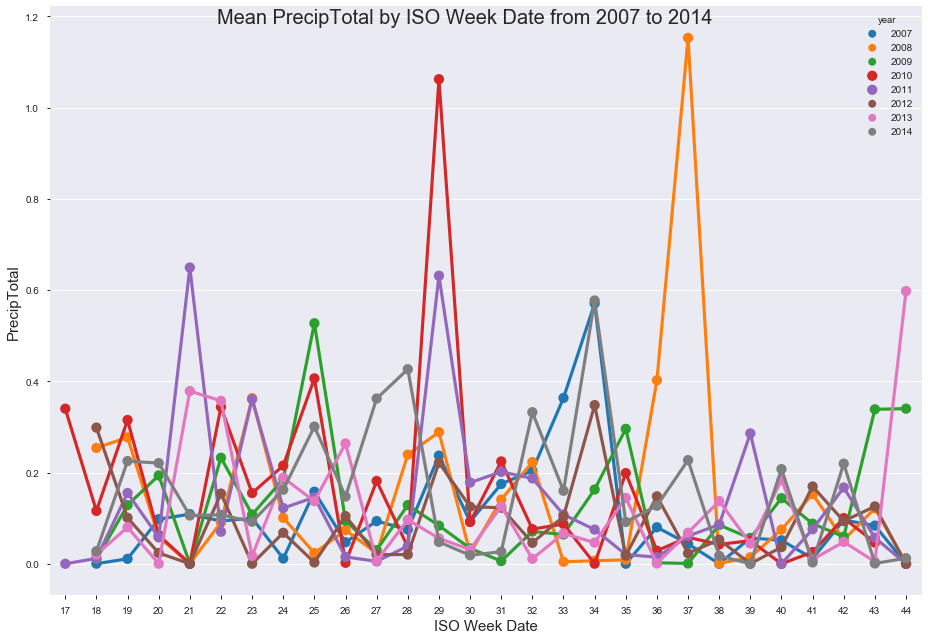

In [34]:
#Plot Mean PrecipTotal by ISO Week Date from 2007 to 2014
fig = plt.figure(figsize=(13,9))
ax1 = fig.add_subplot(111)
ax1 = sns.pointplot(x='week', y="PrecipTotal", hue="year", data=df_weather2.groupby(['year','week'], as_index=False)['PrecipTotal'].mean(),);
plt.suptitle('Mean PrecipTotal by ISO Week Date from 2007 to 2014', fontsize=20)
plt.ylabel('PrecipTotal', fontsize=15)
plt.xlabel('ISO Week Date', fontsize=15);

Based on the above trendlines, there appears to be a spike in total precipitation during ISO Week 21, 25, 29 and 34 for all 8 years with the highest average being on ISO Week 29. There also appears to be an outlier on ISO Week 37 in 2008 where there was a sharp increase in total precipitation to almost 1.2 inches. 

As the West Nile Virus and mosquito breedings tend to thrive better in dry conditions compared to wet conditions, we believe that we should be focusing our efforts on ISO Week 38 to 44 (corresponding to September & October) where Mean Weekly Total Precipitation appears to be the lowest from 2007 to 2014. 

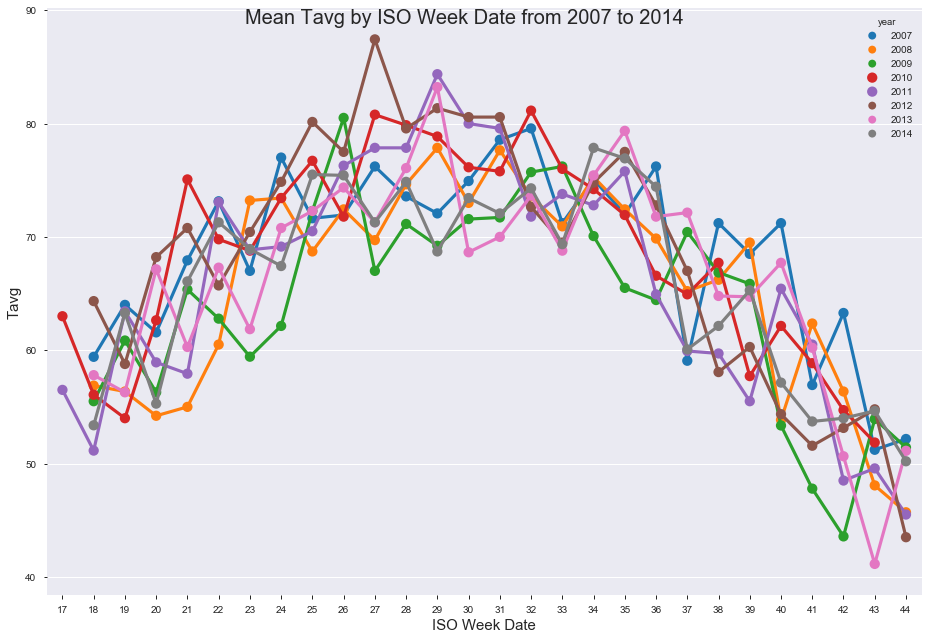

In [35]:
#Plot Mean Tavg by ISO Week Date from 2007 to 2014
fig = plt.figure(figsize=(13,9))
ax1 = fig.add_subplot(111)
ax1 = sns.pointplot(x='week', y="Tavg", hue="year", data=df_weather2.groupby(['year','week'], as_index=False)['Tavg'].mean(),);
plt.suptitle('Mean Tavg by ISO Week Date from 2007 to 2014', fontsize=20)
plt.ylabel('Tavg', fontsize=15)
plt.xlabel('ISO Week Date', fontsize=15);

Based on the above trendlines, the highest average temperature recorded appears to be during the period of ISO Week 25 to 35 for all 8 years with the peak being on ISO Week 27 to 28. No outliers was apparent with weekly mean Tavg rising from ISO Week 17 to 25 then sharply dropping off from ISO Week 35 to 44. 

As the West Nile Virus and mosquito breedings tend to thrive better in hot conditions compared to cold conditions, we believe that we should be focusing our efforts on ISO Week 25 to 35 (corresponding to Late June to August) where Mean Weekly Tavg appears to be the highest from 2007 to 2014. 

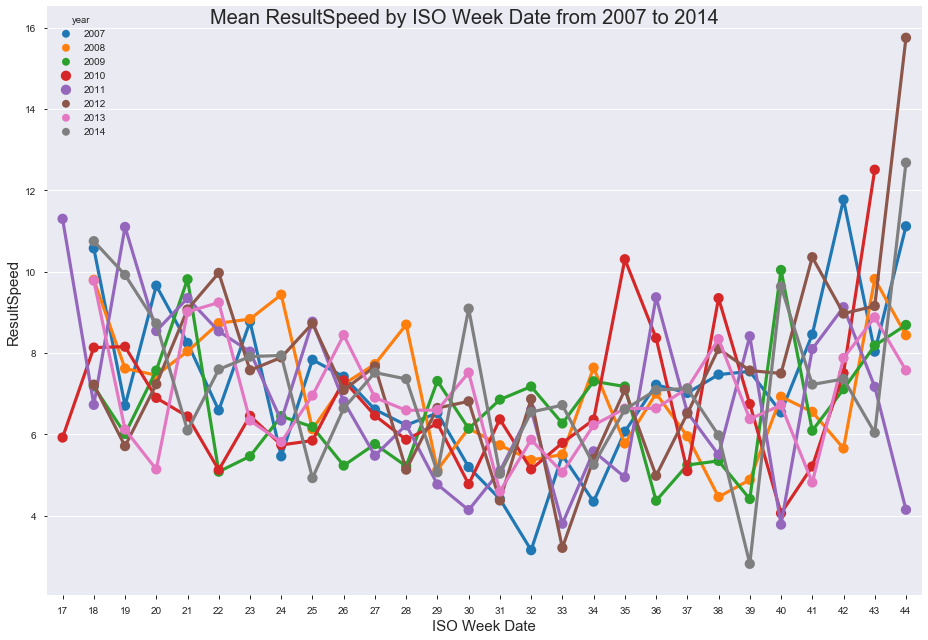

In [36]:
#Plot Mean ResultantSpeed by ISO Week Date from 2007 to 2014
fig = plt.figure(figsize=(13,9))
ax1 = fig.add_subplot(111)
ax1 = sns.pointplot(x='week', y="ResultSpeed", hue="year", data=df_weather2.groupby(['year','week'], as_index=False)['ResultSpeed'].mean(),);
plt.suptitle('Mean ResultSpeed by ISO Week Date from 2007 to 2014', fontsize=20)
plt.ylabel('ResultSpeed', fontsize=15)
plt.xlabel('ISO Week Date', fontsize=15);

Based on the above trendlines, there appears to be a decrease in resultant windspeed during ISO Week 29 to 42 for all 8 years with the lowest resultant windspeed recorded being on ISO Week 33. There also appears to be an outlier on ISO Week 44 in 2011 and 2012 where there was a sharp decrease/increase in resultant windspeed correspondingly.

High resultant windspeeds combined with low air temperatures contribute to the wind chill factor which is an unfavourable condition for the West Nile Virus.

As the West Nile Virus and mosquito breedings tend to thrive better in hotter conditions compared to chill conditions, we believe that we should be focusing our efforts on ISO Week 29 to 42 (corresponding to Late July to October) where Mean Resultant Windspeed appears to be the lowest from 2007 to 2014. 